In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt


In [21]:
# MNIST をコード内で取得（自動ダウンロード）
(x_train, t_train), (x_test, t_test) = keras.datasets.mnist.load_data()

x_train.shape


(60000, 28, 28)

In [22]:
# (N, 28, 28) -> (N, 28, 28, 1)
X_train = x_train[..., None].astype("float32") / 255.0
X_test  = x_test[..., None].astype("float32") / 255.0

X_train.shape


(60000, 28, 28, 1)

In [23]:
def build_simple_cnn(input_shape=(28, 28, 1),
                     filter_num=30, filter_size=5, hidden_size=100, output_size=10):
    model = keras.Sequential(name="SimpleConvNet")
    model.add(layers.Conv2D(filter_num, filter_size, padding="same",
                            activation="relu", kernel_initializer="he_normal",
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(hidden_size, activation="relu", kernel_initializer="he_normal"))
    model.add(layers.Dense(output_size, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model


In [24]:
def build_residual_cnn(input_shape=(28, 28, 1),
                       filter_num=30, hidden_size=100, output_size=10):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(filter_num, 5, padding="same",
                      activation="relu", kernel_initializer="he_normal")(inputs)

    shortcut = x
    x = layers.Conv2D(filter_num, 3, padding="same",
                      activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(filter_num, 3, padding="same",
                      activation=None, kernel_initializer="he_normal")(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hidden_size, activation="relu", kernel_initializer="he_normal")(x)
    outputs = layers.Dense(output_size, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="ResidualConvNet")
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model


In [25]:
EPOCHS = 5
BATCH = 128

simple_model = build_simple_cnn()
res_model = build_residual_cnn()

print("=== Simple CNN ===")
hist_simple = simple_model.fit(
    X_train, t_train,
    epochs=EPOCHS, batch_size=BATCH,
    validation_split=0.1, verbose=1
)

print("\n=== Residual CNN ===")
hist_res = res_model.fit(
    X_train, t_train,
    epochs=EPOCHS, batch_size=BATCH,
    validation_split=0.1, verbose=1
)


=== Simple CNN ===
Epoch 1/5
422/422 [==============================] - 5s 10ms/step - loss: 0.1683 - accuracy: 0.9487 - val_loss: 0.0687 - val_accuracy: 0.9802
Epoch 2/5
422/422 [==============================] - 4s 10ms/step - loss: 0.0525 - accuracy: 0.9842 - val_loss: 0.0508 - val_accuracy: 0.9867
Epoch 3/5
422/422 [==============================] - 4s 10ms/step - loss: 0.0354 - accuracy: 0.9892 - val_loss: 0.0524 - val_accuracy: 0.9863
Epoch 4/5
422/422 [==============================] - 4s 10ms/step - loss: 0.0240 - accuracy: 0.9925 - val_loss: 0.0430 - val_accuracy: 0.9882
Epoch 5/5
422/422 [==============================] - 4s 10ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0506 - val_accuracy: 0.9880

=== Residual CNN ===
Epoch 1/5
422/422 [==============================] - 14s 33ms/step - loss: 0.1379 - accuracy: 0.9572 - val_loss: 0.0516 - val_accuracy: 0.9855
Epoch 2/5
422/422 [==============================] - 13s 30ms/step - loss: 0.0415 - accuracy: 0.9874 - val

In [18]:
simple_test = simple_model.evaluate(X_test, t_test, verbose=0)
res_test = res_model.evaluate(X_test, t_test, verbose=0)

print(f"Simple CNN  : loss={simple_test[0]:.4f}, acc={simple_test[1]:.4f}")
print(f"Residual CNN: loss={res_test[0]:.4f}, acc={res_test[1]:.4f}")


Simple CNN  : loss=0.0487, acc=0.9848
Residual CNN: loss=0.0318, acc=0.9901


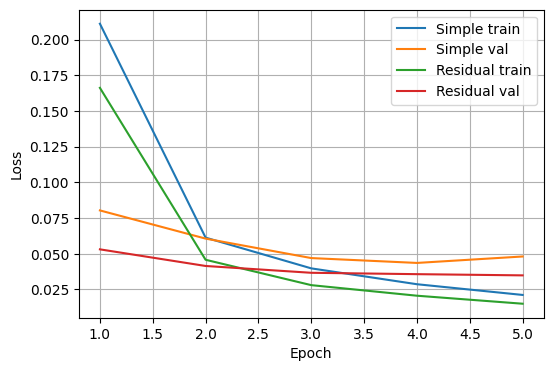

In [19]:
epochs = range(1, len(hist_simple.history["loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, hist_simple.history["loss"], label="Simple train")
plt.plot(epochs, hist_simple.history["val_loss"], label="Simple val")
plt.plot(epochs, hist_res.history["loss"], label="Residual train")
plt.plot(epochs, hist_res.history["val_loss"], label="Residual val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
